# Tracking memory leaks / memory fragmentation

This notebook is for finding out where fastai doesn't allocate GPU RAM efficiently. Feel free to add other sections. Currently it only does a basic training loop, with some unfreezing and inference.

The detection comes from reading the output of [IPyExperimentsPytorch](https://github.com/stas00/ipyexperiments/) per-cell reports.

In particular watch Delta Peak column which may indicate where more GPU RAM was allocated before freeing some, which may lead to smalish holes in allocated GPU RAM which can't be re-used and thus causing fragmentation and leading to less total available GPU RAM.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

In [ ]:
from pathlib import Path
import numpy as np
from ipyexperiments import IPyExperimentsPytorch
#! pip install ipyexperiments

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert str(device) == 'cuda:0', f"we want GPU, got {device}"

In [ ]:
from IPython.display import Markdown, display
def alert(string, color='red'):
    display(Markdown(f"<span style='color:{color}'>**{string}**</span>"))

In [ ]:
# x1 = consume_cpu(2**14) # about 1GB
def consume_gpu(n): return torch.ones((n, n)).cuda()
def consume_1gb(): return [consume_gpu(2**14)]
def consume_6gb(): return [consume_1gb() for x in range(6) ]

def reclaim():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
import tracemalloc, threading, torch, time, pynvml
from fastai.utils.mem import *
from fastai.vision import *

if not torch.cuda.is_available(): raise Exception("pytorch is required")

def preload_pytorch():
    torch.ones((1, 1)).cuda()
    
def gpu_mem_get_used_no_cache():
    torch.cuda.empty_cache()
    return gpu_mem_get().used

def gpu_mem_used_get_fast(gpu_handle):
    info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
    return int(info.used/2**20)

def torch_mem_report():
    torch.cuda.empty_cache()
    print(list(map(lambda x: int(x/2**20), [torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated(), torch.cuda.memory_cached(), torch.cuda.max_memory_cached()])))
    
preload_pytorch()
pynvml.nvmlInit()

class PeakMemMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder

    def peak_monitor_start(self):
        self.peak_monitoring = True

        # start RAM tracing
        tracemalloc.start()

        # this thread samples RAM usage as long as the current epoch of the fit loop is running
        peak_monitor_thread = threading.Thread(target=self.peak_monitor_func)
        peak_monitor_thread.daemon = True
        peak_monitor_thread.start()
        
    def peak_monitor_stop(self):
        tracemalloc.stop()
        self.peak_monitoring = False
        
    def peak_monitor_func(self):
        self.gpu_mem_used_peak = -1

        gpu_id = torch.cuda.current_device()
        gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_id)

        while True:
            gpu_mem_used = gpu_mem_used_get_fast(gpu_handle)
            self.gpu_mem_used_peak = max(gpu_mem_used, self.gpu_mem_used_peak)
            if not self.peak_monitoring: break
            time.sleep(0.001) # 1msec

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['cpu used',  'peak', 'gpu used',  'peak'])
                    
    def on_epoch_begin(self, **kwargs):
        self.peak_monitor_start()
        self.gpu_before = gpu_mem_get_used_no_cache()

    def on_epoch_end(self, **kwargs):
        cpu_current, cpu_peak =  list(map(lambda x: int(x/2**20), tracemalloc.get_traced_memory()))
        gpu_current = gpu_mem_get_used_no_cache() - self.gpu_before
        gpu_peak    = self.gpu_mem_used_peak      - self.gpu_before
        self.peak_monitor_stop()
        # The numbers are deltas in MBs (beginning of the epoch and the end)
        self.learn.recorder.add_metrics([cpu_current, cpu_peak, gpu_current, gpu_peak])

# Prep dataset

In [ ]:
exp1 = IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 Ti (8119 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2277  9470  31588 MB   7.21% 
GPU:  1474  6645   8119 MB  18.15% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0.000s
･ CPU:         0       0     2277 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
path = untar_data(URLs.MNIST)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.004s
･ CPU:         0       1     2278 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
# setup
defaults.cmap='binary'
bs=512
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
#arch="resnet34"
arch="resnet50"

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.007s
･ CPU:         0       0     2278 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
il = ImageItemList.from_folder(path, convert_mode='L')
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.512s
･ CPU:        26       0     2350 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png;

Test: None

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.115s
･ CPU:         8       4     2360 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
src = sd.label_from_folder()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.179s
･ CPU:         0       0     2360 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
ll = src.transform(tfms)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.001s
･ CPU:         0       0     2360 MB |
･ GPU:         0       0     1474 MB |


4


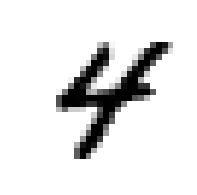

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.317s
･ CPU:         0       1     2362 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)
x,y = data.train_ds[0]
x.show()
print(y)

# Train and Validate


In [ ]:
model = getattr(models, arch) # models.resnet34

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.001s
･ CPU:         0       0     2362 MB |
･ GPU:         0       0     1474 MB |


In [ ]:
learn = create_cnn(data, model, metrics=[accuracy], callback_fns=PeakMemMetric)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.792s
･ CPU:         0       0     2522 MB |
･ GPU:       106       0     1580 MB |


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 16.813s
･ CPU:         0       0     2532 MB |
･ GPU:        14    6206     1594 MB |


In [ ]:
# 2nd time to check for leaks
learn.lr_find()
# gpu delta consumed should be zero
# but why peaked is much smaller?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 12.733s
･ CPU:         0       0     2533 MB |
･ GPU:         0     964     1594 MB |


In [ ]:
reclaim() # resets lr_find's GPU RAM consumption

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.039s
･ CPU:         0       0     2533 MB |
･ GPU:         0       0     1594 MB |


In [ ]:
learn.recorder.plot()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.025s
･ CPU:         0       0     2533 MB |
･ GPU:         0       0     1594 MB |


In [ ]:
learn.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.216379,0.062475,0.979200,0,2,42,3968


･ RAM: △Consumed △Peaked  Used Total | Exec time 19.321s
･ CPU:         0       0     2533 MB |
･ GPU:        26    3942     1620 MB |


In [ ]:
# cycle this:
learn.fit_one_cycle(1, max_lr=1e-2)
learn.fit_one_cycle(2, max_lr=1e-2)
learn.save(f'reload1')
_=learn.load(f'reload1')
reclaim() # resets lr_find's GPU RAM consumption

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.076905,0.033432,0.989500,0,2,14,954


epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.074024,0.071492,0.977700,0,2,14,954
2,0.046048,0.024421,0.991800,0,2,6,944


･ RAM: △Consumed △Peaked  Used Total | Exec time 54.109s
･ CPU:         0       0     2534 MB |
･ GPU:         0     958     1620 MB |


In [ ]:
reclaim() # resets fit_one_cycle's GPU RAM consumption

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.040s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0     1620 MB |


In [ ]:
learn.save(f'reload1')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.187s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0     1620 MB |


### Proposed Change
end of `learn.load()` is a place where reclaim should be executed, so that the GPU RAM taken previously by the model is unloaded - otherwise it's doubled in size until gc.collect() arrives some time in the future.

Currently, we get delta peaked reported @ 126MB for models.resnet34, and it should be 0 peaked, if first the model is unloaded and then loaded again.

In [ ]:
_=learn.load(f'reload1')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.096s
･ CPU:         0       0     2534 MB |
･ GPU:         0     126     1620 MB |


In [ ]:
cpu_mem, gpu_mem, time_data = exp1.cl.data
if b2mb(gpu_mem.peaked_delta) > 10:
    alert(f"load() caused potential fragmentation by not unloading model first, delta peaked at {b2mb(gpu_mem.peaked_delta)} MB")

<span style='color:red'>**load() caused potential fragmentation by not unloading model first, delta peaked at 126 MB**</span>

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.002s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0     1620 MB |


In [ ]:
reclaim() # resets load's GPU RAM consumption

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.040s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0     1620 MB |


In [ ]:
#reclaim_tensors()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.052s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0     1620 MB |


In [ ]:
learn.lr_find(end_lr=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 12.918s
･ CPU:         0       0     2535 MB |
･ GPU:         0     954     1620 MB |


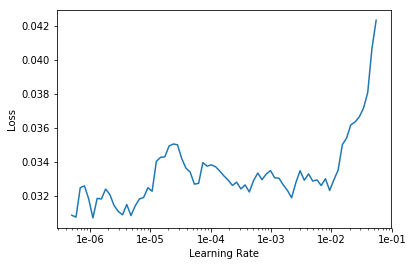

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.355s
･ CPU:         0       1     2535 MB |
･ GPU:         0       0     1620 MB |


In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.053931,0.026953,0.991700,0,2,4,954


･ RAM: △Consumed △Peaked  Used Total | Exec time 18.119s
･ CPU:         0       0     2535 MB |
･ GPU:         0     954     1620 MB |


In [ ]:
learn.save(f'leak2')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.146s
･ CPU:         0       0     2535 MB |
･ GPU:         0       0     1620 MB |


## Fine tuning

In [ ]:
_=learn.load(f'leak2')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.096s
･ CPU:         0       0     2535 MB |
･ GPU:         0     126     1620 MB |


In [ ]:
learn.unfreeze()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.004s
･ CPU:         0       0     2535 MB |
･ GPU:         0       0     1620 MB |


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 12.692s
･ CPU:         0       0     2535 MB |
･ GPU:       226    3486     1846 MB |


In [ ]:
# 2nd time to check for leaks
learn.lr_find()
# gpu delta consumed should be zero

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 10.294s
･ CPU:         0       0     2535 MB |
･ GPU:         0     944     1846 MB |


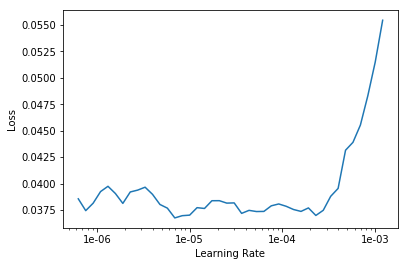

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.313s
･ CPU:         0       1     2535 MB |
･ GPU:         0       0     1846 MB |


In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-2
learn.fit_one_cycle(1, slice(1e-5, lr/5))
# XXX: something is wrong here measurement-wise
# callback reports peak of 942 vs. cell peak reports at 432 - the measuring thread of the cell probably missed that higher peak - need to switch to the new pytorch max_memory_allocated with reset_ to get the exact measurement. must wait for pytorch-1.0.1 to be out.
# 

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.040549,0.024023,0.991800,0,2,510,942


･ RAM: △Consumed △Peaked  Used Total | Exec time 21.576s
･ CPU:         0       0     2535 MB |
･ GPU:       494     432     2340 MB |


In [ ]:
learn.save(f'leak3')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.359s
･ CPU:         0       1     2535 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
learn.freeze()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.004s
･ CPU:         0       0     2535 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
learn.export()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.178s
･ CPU:         0      98     2535 MB |
･ GPU:         0       0     2340 MB |


# Inference via learn.export

In [ ]:
learn = load_learner(path, test=ImageItemList.from_folder(path/'testing'))

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.155s
･ CPU:         3     106     2537 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
learn.data.test_ds
len(learn.data.test_ds)

LabelList
y: EmptyLabelList (10000 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (10000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png

10000

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.004s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

･ RAM: △Consumed △Peaked  Used Total | Exec time 3.227s
･ CPU:         0       0     2537 MB |
･ GPU:         0    2596     2340 MB |


In [ ]:
len(predictions[0])

10000

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.002s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
# get predictions as numpy
pred = predictions[0].numpy()
pred[0]
pred_df = pd.DataFrame(pred)
pred_df[:5]
#pred_df.sort_values(by="preds")

array([1.266012e-07, 1.467593e-06, 9.686403e-07, 2.154748e-08, 9.999814e-01, 7.464445e-08, 3.189584e-06, 4.764192e-06,
       2.979431e-06, 4.936371e-06], dtype=float32)

,0,1,2,3,4,5,6,7,8,9
0,1.266012e-07,0.000001,9.686403e-07,2.154748e-08,0.999981,7.464445e-08,0.000003,0.000005,0.000003,0.000005
1,2.941443e-05,0.000084,6.121457e-05,8.575105e-06,0.992541,1.012440e-05,0.000067,0.000626,0.000338,0.006233
2,8.962942e-05,0.000127,1.539169e-04,2.455930e-05,0.975272,4.038281e-05,0.000182,0.000300,0.000827,0.022983
3,1.213701e-07,0.000002,2.753096e-07,2.414696e-08,0.999970,1.101933e-07,0.000003,0.000005,0.000005,0.000013
4,8.470987e-06,0.000051,8.441069e-06,3.164073e-06,0.997919,1.190504e-05,0.000059,0.000078,0.001198,0.000663


･ RAM: △Consumed △Peaked  Used Total | Exec time 0.038s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0     2340 MB |


# Inference with manual learn re-construction

In [ ]:
del learn
gc.collect()
#learn.opt.clear()
torch.cuda.empty_cache()

0

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.046s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
#del exp1

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.000s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
bs = 32
tfms = get_transforms(do_flip=False)


･ RAM: △Consumed △Peaked  Used Total | Exec time 0.025s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0     2340 MB |


In [ ]:
data = (src.add_test_folder(test_folder='testing')
        .transform(tfms) # .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn = create_cnn(data, model)
_=learn.load(f'leak3')


･ RAM: △Consumed △Peaked  Used Total | Exec time 0.936s
･ CPU:         3       1     2552 MB |
･ GPU:      -460     654     1880 MB |


In [ ]:
# learn.data = (src.add_test_folder(test_folder='test')
#         .transform(tfms) # .transform(tfms, size=256)
#         .databunch().normalize(imagenet_stats))

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.000s
･ CPU:         0       0     2552 MB |
･ GPU:         0       0     1880 MB |


In [ ]:
learn.data.test_ds
len(learn.data.test_ds)

LabelList
y: EmptyLabelList (10000 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png

10000

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.039s
･ CPU:         0       0     2552 MB |
･ GPU:         0       0     1880 MB |


In [ ]:
#learn.validate()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.000s
･ CPU:         0       0     2551 MB |
･ GPU:         0       0     1880 MB |


In [ ]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

# need to also try learn.TTA()

･ RAM: △Consumed △Peaked  Used Total | Exec time 2.293s
･ CPU:         0       0     2552 MB |
･ GPU:         0       0     1880 MB |


In [ ]:
len(predictions[0])

10000

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.002s
･ CPU:         0       0     2552 MB |
･ GPU:         0       0     1880 MB |


In [ ]:
# get predictions as numpy
pred = predictions[0].numpy()
pred[0]
pred_df = pd.DataFrame(pred)
pred_df[:5]
#pred_df.sort_values(by="preds")

array([1.266012e-07, 1.467593e-06, 9.686403e-07, 2.154748e-08, 9.999814e-01, 7.464445e-08, 3.189584e-06, 4.764192e-06,
       2.979431e-06, 4.936371e-06], dtype=float32)

,0,1,2,3,4,5,6,7,8,9
0,1.266012e-07,0.000001,9.686403e-07,2.154748e-08,0.999981,7.464445e-08,0.000003,0.000005,0.000003,0.000005
1,2.941443e-05,0.000084,6.121457e-05,8.575105e-06,0.992541,1.012440e-05,0.000067,0.000626,0.000338,0.006233
2,8.962942e-05,0.000127,1.539169e-04,2.455930e-05,0.975272,4.038281e-05,0.000182,0.000300,0.000827,0.022983
3,1.213701e-07,0.000002,2.753096e-07,2.414696e-08,0.999970,1.101933e-07,0.000003,0.000005,0.000005,0.000013
4,8.470987e-06,0.000051,8.441069e-06,3.164073e-06,0.997919,1.190504e-05,0.000059,0.000078,0.001198,0.000663


･ RAM: △Consumed △Peaked  Used Total | Exec time 0.037s
･ CPU:         0       0     2552 MB |
･ GPU:         0       0     1880 MB |
